In [42]:
import tensorflow as tf
from tensorflow.python.keras.layers import Input, Dense, preprocessing, Conv2D, MaxPooling2D, Activation, Dropout, Flatten, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.backend import backend as K
from tensorflow.python.keras.backend import eval
from tensorflow.python.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.callbacks import TensorBoard
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Plot training data

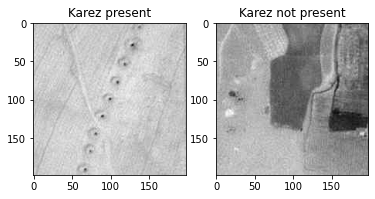

(198, 198)


In [43]:
#--- plot a training image 
import os
import matplotlib.image as img
import matplotlib.pyplot as plt

dirPath = 'C:/sarah/kfold/buffer100_scale/'

fname = os.path.join(dirPath, 'train/karez/shaft_006.jpg')


image = img.imread(fname)
plt.subplot(1,2,1)
plt.imshow(image, cmap ='gray')
plt.title('Karez present')


fname = os.path.join(dirPath, 'train/nokarez/shaft_006.jpg')
image = img.imread(fname)
plt.subplot(1,2,2)
plt.imshow(image, cmap ='gray')
plt.title('Karez not present')
plt.show()

print(image.shape)

Set up default hyperparameters and constants

In [44]:
l2_param                = 0.1    # 0.001 L2 regularisation to prevent overfit 0-0.1
momentum_param          = 0.9    # default 0.99 reducing it to dampen oscillations
lr_param                = 0.0001 # default 0.001 
batch_size              = 16     
num_of_valid_samples    = 720
num_of_train_samples    = 2960
imx                     = image.shape[0]
imy                     = image.shape[1]
epoch                   = 30

Set up the network topology. The Adam optimiser uses an adaptive learning rate 
so no need to use the LearningRateScheduler 

In [45]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(imx, imy, 1),padding='valid',kernel_regularizer=tf.keras.regularizers.l2(l2_param)))
model.add(Activation('relu'))
model.add(BatchNormalization(momentum=momentum_param))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(l2_param)))
model.add(Activation('relu'))
model.add(BatchNormalization(momentum=momentum_param))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(l2_param)))
model.add(Activation('relu'))
model.add(BatchNormalization(momentum=momentum_param))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(tf.keras.optimizers.Adam(lr=lr_param),
              loss='binary_crossentropy',
              metrics=['accuracy'])


Augment the training data and rescale 0-1

In [46]:
train_datagen = ImageDataGenerator(
                rotation_range=180,
                width_shift_range=0.1,
                height_shift_range=0.1,
                rescale=1./255,
                shear_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True,
                fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        dirPath + '/train',
        target_size=(imx, imy),
        batch_size=batch_size,
        color_mode='grayscale',
        shuffle=True,
        seed=42,
        class_mode='binary')

Found 2960 images belonging to 2 classes.


Validation data. Using an 80% (train) and 20% (validate) split. 
No need to augment the validation data, just rescale it. 

In [47]:
valid_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = valid_datagen.flow_from_directory(
        dirPath + '/valid/',
        target_size=(imx, imy),
        batch_size=batch_size,
        color_mode='grayscale',
        shuffle=True,
        seed=42,
        class_mode='binary')


Found 740 images belonging to 2 classes.


Set up a call back to stop early if the validation loss has stopped decreasing

In [48]:
tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=2,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


Train the model

In [ ]:
history = model.fit(
        train_generator,
        epochs=epoch,
        shuffle=True,
        callbacks=[callback], 
        verbose=1,
        steps_per_epoch=num_of_train_samples//batch_size,
        validation_data=validation_generator)


Epoch 1/30
185/185 [==============================] - 132s 711ms/step - loss: 10.1146 - accuracy: 0.6635 - val_loss: 7.0524 - val_accuracy: 0.6324
Epoch 2/30
185/185 [==============================] - 149s 807ms/step - loss: 5.1105 - accuracy: 0.7041 - val_loss: 3.6864 - val_accuracy: 0.6595
Epoch 3/30
185/185 [==============================] - 148s 798ms/step - loss: 2.7425 - accuracy: 0.7561 - val_loss: 2.0230 - val_accuracy: 0.8135
Epoch 4/30
185/185 [==============================] - 143s 774ms/step - loss: 1.6304 - accuracy: 0.8182 - val_loss: 1.4085 - val_accuracy: 0.8068
Epoch 5/30
185/185 [==============================] - 142s 765ms/step - loss: 1.0608 - accuracy: 0.8632 - val_loss: 1.0516 - val_accuracy: 0.7689
Epoch 6/30
185/185 [==============================] - 153s 829ms/step - loss: 0.7452 - accuracy: 0.9044 - val_loss: 1.5538 - val_accuracy: 0.6554
Epoch 7/30
185/185 [==============================] - 150s 811ms/step - loss: 0.5873 - accuracy: 0.9125 - val_loss: 0.6416 

In [ ]:
print(history.history.keys())

model.summary()


In [ ]:
loss_train = history.history['loss']
loss_val   = history.history['val_loss']

acc_train  = history.history['accuracy']
acc_val    = history.history['val_accuracy']

plt.subplot(2,1,1)
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.subplot(2,1,2)
plt.plot(acc_train, 'g', label='Training accuracy')
plt.plot(acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
